# **VARIATIONAL CLASSIFIER**

Variational Classifier is a Variational Circuit which is used to classify the dataset based on some parameters. It is analogous to a Quantum Neural Network, which also works in a similar way. The Variational Classifier here is used to work on Classical Dataset.

  **1. Parity Identifier**
  
  The parity function is a functions which returns the output of 1 when there is an uneven i.e odd numbers of 1's in the input x and 0 or here, -1 otherwise.

   * f : x∈{0,1}⊗n → y={1 if uneven number of 1's in x | 0 otherwise.


It demonstrates how to encode binary inputs into the initial state of the variational circuit, which is simply a computational basis state (basis encoding).


In [ ]:
pip install pennylane            #Installing the Pennylane environment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 19.9 MB/s eta 0:00:00


In [ ]:
import pennylane as qml                        #Importing packages from pennylane
from pennylane import numpy as np

In [ ]:
from pennylane.optimize import NesterovMomentumOptimizer  #importing the optimizer function

First we define the Layer which essentially is an elementary circuit architecture that gets repeated to build the full Variational Circuit.

Here the Layer, "layer" is defines as a circuit consisting of 4 qubits or wires having applied to each a Rot function, which is basically a conscutive tranformation of RZ, RY and RZ gates respectively. Then a CNOT gate is applied among the adjacent qubits so as to entangle them to their neighbours.

****

**#1** Creating a device to run the circuit on. These devices are generated for running the quantum circuit operations.

**#2** Here the Rot function is applied to each of the qubit. Rot function consists of a sequetial transformation in the order : RZ, RY and RZ.

**#3** Neighbouring qubits are applied a CNOT gate to them so that these pairs of qubits are entangled.


*****
Step 2&3 are part of the "Layer" or "block" formation, where layer refers to an elementary circuit architecture that gets repeated to build the full variational circuit.
****

In [ ]:
dev = qml.device("default.qubit")                  #1
def layer(layer_weights):
    for wire in range(4):
        qml.Rot(*layer_weights[wire], wires=wire)  #2

    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]): #3
        qml.CNOT(wires)

 This is the state preparation function that basically creates the Basis state of qubits according to the input string. Here the places where there is 1 in the input string is encoded as 1 in the Basis state qubits and similarly with the 0 as well.
 ****

**#4** Defines the state preparation function with the data input x. The inputs are bitstrings, which we encode into the state of the qubits. The quantum state ψ after state preparation is a computational basis state that has 1s where x has 1s, and 0s where x has 0s.

In [ ]:
def state_preparation(x):                   #4
    qml.BasisState(x, wires=[0, 1, 2, 3])

Here we define the Variational Classifier circuit where the previously defined layer structure namely layer is repeated to complete the circuit.
****

**#5** This esentially is the definition of the Variational Circuit, which takes two inputs : wights and x, where x is the input bitstring.

**#6** State preparation function is used here to convert the input bitstring into a qubit state vector.

**#7** This step is where the layer structure is applied repetitively.

**#8** This step returns the Expected value of the computed circuit transformed to its Pauli Z counterpart.

In [ ]:
@qml.qnode(dev)
def circuit(weights, x):                       #5
    state_preparation(x)                       #6

    for layer_weights in weights:              #7
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))           #8

Here we postprocess the above Variational Clssifier to add a classical trainable Bias term to the circuit.

In [ ]:
def variational_classifier(weights, bias, x):              # define the variational classifier circuit
    return circuit(weights, x) + bias

**Cost**

This is the step that applies the Supervised Learning of the Machine Learning Algorithm. In supervised learning, the cost function is defined in order to devise the best fitting solution to the ML model. The Cost function is defined as the sum of the Loss funtion and the regulazier.

*****

**#9** This is the Square loss function. This is defined as the mean of the square of the difference between labels and the predictions of all the datapoints. This essentially is the diatance between the target labels and the model's predictions.

**#10** This is the function that checks for the accuracy of the predicted values against the labels. It is the proportion of predictions that agree with a set of target labels. This is defined to monitor how many inputs the current classifier predicted correctly.

**#11** This is the Cost function which actually produces the predictions for the above functions. This function depends on the features and the labels of the optimization routine. It defines how well the model works for the input data and how it can furthur be optimized.


In [ ]:
def square_loss(labels, predictions):                                 #9
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def accuracy(labels, predictions):                                    #10
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(weights, bias, X, Y):                                        #11
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

**Optimization**

This is the Optimization process of the model. Here the two datasets namely : parity_test and parity_train are used to train as well as test the model. This step basically gives the best optimized value of our Variational Circuit.
****

**#12** This step loads the data from parity_test to the model for the learning purposes.

**#13** This along with the above steps are responsible for learning the parity function and use this learning along with the above defined Cost function to determine the predicted labels for the data in the parity_test dataset, 1 for the odd parity and -1 for even parity.

Next steps are for printing these predicted values along with their qubit state vectors on which this model has been trained.

In [ ]:
data = np.loadtxt("parity_train.txt", dtype=int)                      #12
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}                   #13

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


These lines of code calculates the Weights and Bias for the model. This involves the random initialization of the variables however a seed is defined for the purposes of reproducibilty.

Reproducibility is enabled in order to ensure the credibility of the results every time it is executed.

Only a single variable is treated as bias whilst the rest of them are used as an input to the variational circuit.

In [ ]:
np.random.seed(0)                                          #initializing random values
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)         #claculating the weights ans bias
bias_init = np.array(0.0, requires_grad=True)
print("Weights:", weights_init)
print("Bias: ", bias_init)

Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]
Bias:  0.0


**#14** Here we first define an optimizer instance of batch size 5 from the builtin libraray of optimizers provided by pennylane and then eventually run it to train our model.

**#15** Here we compute the accuracy of our model and turn it into predictions {-1,1}.

****

The classifier is able to predict all the training set data correctly. However our model should be able to predict the cirrect values for the data it has never seen before as well hence we will be using the test data from before for the unsupervised learning.

In [ ]:
opt = NesterovMomentumOptimizer(0.5)                   #14
batch_size = 5

weights = weights_init
bias = bias_init
for it in range(100):                                                             #15
    batch_index = np.random.randint(0, len(X), (batch_size,))                     # Update the weights by one optimizer step, using only a limited batch of data
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)           #applying the optimizer

    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]  # Computing the accuracy

    current_cost = cost(weights, bias, X, Y)                                      #computed cost and accuracy
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:    1 | Cost: 2.3147651 | Accuracy: 0.5000000
Iter:    2 | Cost: 1.9664866 | Accuracy: 0.5000000
Iter:    3 | Cost: 1.9208589 | Accuracy: 0.5000000
Iter:    4 | Cost: 2.6276126 | Accuracy: 0.5000000
Iter:    5 | Cost: 0.9323119 | Accuracy: 0.6000000
Iter:    6 | Cost: 1.1903549 | Accuracy: 0.5000000
Iter:    7 | Cost: 2.0508989 | Accuracy: 0.4000000
Iter:    8 | Cost: 1.1275531 | Accuracy: 0.6000000
Iter:    9 | Cost: 1.1659803 | Accuracy: 0.6000000
Iter:   10 | Cost: 1.1349618 | Accuracy: 0.6000000
Iter:   11 | Cost: 0.9994063 | Accuracy: 0.6000000
Iter:   12 | Cost: 1.0812559 | Accuracy: 0.6000000
Iter:   13 | Cost: 1.2863155 | Accuracy: 0.6000000
Iter:   14 | Cost: 2.2658259 | Accuracy: 0.4000000
Iter:   15 | Cost: 1.1323724 | Accuracy: 0.6000000
Iter:   16 | Cost: 1.3439737 | Accuracy: 0.8000000
Iter:   17 | Cost: 2.0076168 | Accuracy: 0.6000000
Iter:   18 | Cost: 1.2685760 | Accuracy: 0.5000000
Iter:   19 | Cost: 1.6762475 | Accuracy: 0.5000000
Iter:   20 | Cost: 1.1868237 | 

**#16** Inthese steps we are predicting the weights and bias for the model using the test data which was loaded into the environment in the previous lines of the same block of code.

**#17** These lines of code prints the predicted values of the test dataset. The next lines of code however check for the acuuracy of the model by calculating the accuracy function and in order to find the good minima leading to well generalising minima.

****


In [ ]:
data = np.loadtxt("parity_test.txt", dtype=int)                                         #using the test data;
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}
                                                                                        #16
predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]  #predicting the values using the variational classifier we just defined

for x,y,p in zip(X_test, Y_test, predictions_test):                                     #17
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)



x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0
Accuracy on unseen data: 1.0


****
As we can see from the output of the code, the model has correctly predicted the values for the unseen test dataset and hence we can conclude this encoding strategy to be on of the optimal choices.

This encoding strategy creates quanutm states from the dataset that has zero overlap i.e the states created from the test set have no overlap with the states from the training dataset and hence is in itself quite a remarkable feat.

****

# **Iris classification**

This classification is different from the above in the sense that here the input is not in the form of bitstrings rather is represented in the form of a real-valued vectors. These vectors are 2-dimensional and we encode them into 2 qubits by using some latent vectors in addition to the input vectors.

Remember, for simplicity only the positive values are taken as the negative values would require in the state_preparation() function another rotation along the Z-axis.

****

**#1** Here the state prepapration is not the same as that of the above case, here the input x is to be translated into a set of angles which can then be furthur processed into the state_preparation() function.


In [ ]:
def get_angles(x):                                                                       #1
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))   #Defining the input x into some angles
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])               #Returned angles are then input into the state_preparation()

                                                                                         #function in order to get the states.
def state_preparation(a):
    qml.RY(a[0], wires=0)                                                                #rotation  qubit 0 along y-axis

    qml.CNOT(wires=[0, 1])                                                               #qubit 0 and 1 are entangled
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

The following code routine is to check for the above code if it works correctly or not. As we can see in the output, it is clear that the above lines of code work perfectly fine.

In [ ]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):
    state_preparation(angles)

    return qml.state()


state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968  0.795036  0.278265 -0.      ]


****
**#2** Here we define the layer() function for 2 qubits as we are working on two qubits only. The function definition is the same as above where one Rot() function is applied to each and the CNOT gate is applied to the 0 and 1 qubit.

**#3** We again define the cost function to track for the accuracy of the model we define in the following code cells.
Here the variational_classifier from the previous definition is being used and return the square_loss.

In [ ]:
def layer(layer_weights):                                       #2
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])


def cost(weights, bias, X, Y):                                  #3
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

*****
**Data**


**#4** We load the iris dataset into the environment that is to be used for the furthur processing of the model.

**#5** We add two more rows of value 0.1 in order to ensure the size of the vector to be consistent for the furthur operation.

**#6** Next is the normalization step, where each state is normalized. Normalization is a process that is used to convert the amplitude of each state such that the cumulative amplitude becomes unity. Normalization is necessary for consisitentcy as  well.

**#7** The features i.e the input is taken and processed in the form of angles for the state preparation as described above in the get_angles() function definition.

In [ ]:
data = np.loadtxt("VC_FILE.txt")                                  #4
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

padding = np.ones((len(X), 2)) * 0.1                              #5
X_pad = np.c_[X, padding]                                         # pad the vectors to size 2^2=4 with constant values
print(f"First X sample (padded)    : {X_pad[0]}")

normalization = np.sqrt(np.sum(X_pad**2, -1))                     #6
X_norm = (X_pad.T / normalization).T                              # normalize each input
print(f"First X sample (normalized): {X_norm[0]}")

features = np.array([get_angles(x) for x in X_norm], requires_grad=False)  #7
print(f"First features sample      : {features[0]}")              # the angles for state preparation are the features

Y = data[:, -1]


First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.1  0.1 ]
First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]
First features sample      : [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


****
These angles formed in the above snippet are the new features and the following code is for preprocessing which involves tweaking the dimensions namely, dim1 and dim2 to separate the classes. Not all results would be very informative but mostly will offer something to infer.

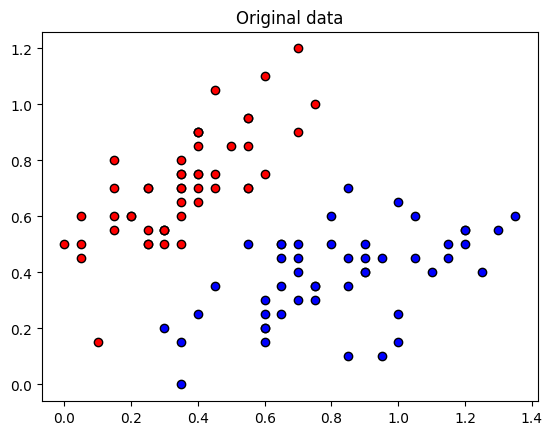

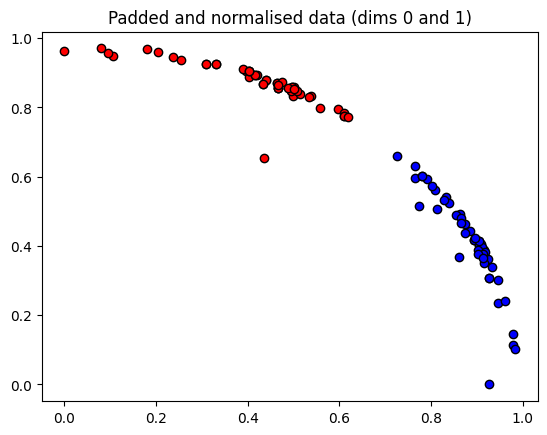

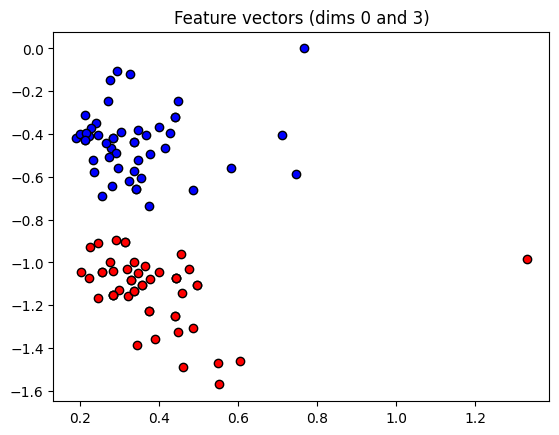

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()

****
In this block of code we are trying to train our model on one set of data and text it onto the other set of data. Hence, we also have divided the data into a training set and validation set separately which also helps in monitoring the data.

In [ ]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

**Optimization**

**#8** This step in the code is included to Inititalize the variables. Here we again asign a random variable to initialize the weight.

**#9** These lines of code are for training the variational optimizer. Here again Nesterov Moment optimizer is used to training.

**#10**  This is done to train the variational classifier. It is done by updating the weights by one optimizer step and computing predictions on training and validation set.

**#11** Here we compute accuracy on train and validation set.

In [ ]:
num_qubits = 2                             #8
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = NesterovMomentumOptimizer(0.01)                          #9
batch_size = 5

weights = weights_init                                         #10
bias = bias_init
for it in range(60):
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))


    acc_train = accuracy(Y_train, predictions_train)                            #11
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )


Iter:     2 | Cost: 1.6754956 | Acc train: 0.4729730 | Acc validation: 0.5600000
Iter:     4 | Cost: 1.2150141 | Acc train: 0.4864865 | Acc validation: 0.5600000
Iter:     6 | Cost: 0.9753521 | Acc train: 0.5000000 | Acc validation: 0.6800000
Iter:     8 | Cost: 0.9635075 | Acc train: 0.6216216 | Acc validation: 0.6400000
Iter:    10 | Cost: 0.9524853 | Acc train: 0.6351351 | Acc validation: 0.6400000
Iter:    12 | Cost: 0.9544315 | Acc train: 0.4729730 | Acc validation: 0.6000000
Iter:    14 | Cost: 1.0563986 | Acc train: 0.4864865 | Acc validation: 0.5600000
Iter:    16 | Cost: 1.0992387 | Acc train: 0.4864865 | Acc validation: 0.5600000
Iter:    18 | Cost: 1.0174890 | Acc train: 0.4729730 | Acc validation: 0.5600000
Iter:    20 | Cost: 0.9134476 | Acc train: 0.5405405 | Acc validation: 0.6800000
Iter:    22 | Cost: 0.8519582 | Acc train: 0.6486486 | Acc validation: 0.6400000
Iter:    24 | Cost: 0.8393299 | Acc train: 0.5675676 | Acc validation: 0.5200000
Iter:    26 | Cost: 0.799369

****
This block of code is for plotting a model onto a graph to see the projection as well as accuracy, etc. of our model in a graphical format.

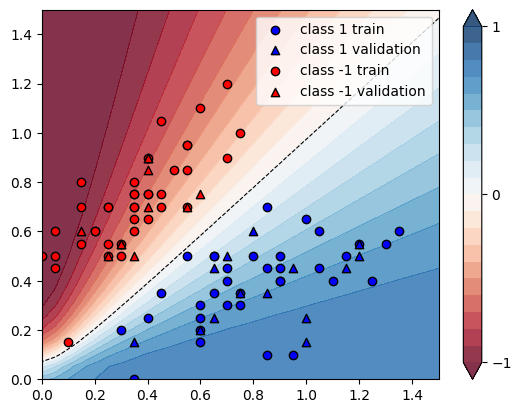

In [ ]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()